In [1]:
import networkx as nx
import pandas as pd
import numpy as np
#from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from tensorflow import keras
from networkx.linalg.graphmatrix import adjacency_matrix
from scipy.special import softmax
import networkx.generators.classic as Graphs
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import identity
import time
from mpl_toolkits import mplot3d
%matplotlib inline
import random as rd


Bad key "text.kerning_factor" on line 4 in
C:\Users\tarik\Anaconda3\envs\graphs\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def normalise_weights(G,max_weight=None,convert=False):
    '''
    using softmax function
    '''
    n = len(G.nodes)
    
    #l = set(list(range(1,n+1)))
    
    #print(l)
    
    M = adjacency_matrix(G,nodelist=G.nodes())#,nodelist=l)
    
    #M = nx.convert_matrix.to_numpy_matrix(G)
    rows = M.nonzero()[0]
    cols = M.nonzero()[1]
    
    
    index = list(zip(rows,cols))
    #print(tuple(index))
    print("matrix shape :  " + str(M.shape[1]) +" X "  +  str(M.shape[0]) )
    count  = 0
    if convert:
        for i in index:
                M[i] = max_weight - M[i] 
                #print(str(i)+'      ' +str(M[0,i]))
                count = count +1 
                if count > 100:
                    break

    ## Softmax
    L = M.tolil()
    L = L.asfptype()
    #print(L.todense())
    #ind =M.indices
    #for i in ind:
     #   print(M[i])
    for i in range(len(L.rows)):
        X = []
        #print(L.rows[i])
        for j in L.rows[i]:
            X.append(L[i,j])
            
        X = softmax( np.array(X))
        c = 0
        for j in L.rows[i]:
            #print(X[c])
            L[i,j] = X[c]
            #print(L[i,j])
            c=c+1
        #print (X)
        del(X)
    #print(L.todense())
    '''
    for i in range(10):# range(M.shape[1]):
        edge = list(M.nonzero())
        print(edge)
        for j in range(len(edge[0])):
            print( str(edge[0][j])+"   "+str(edge[1][j])+"    "+str(edge))#+str(M[edge]))

        X = softmax( np.array([ M[edge] for edge in list(zip(M[i,:].nonzero()[0],M[i,:].nonzero()[1])) ])  )
        #print(X)
        del(X)
    '''
    return L
    

In [3]:
def create_transaction_M(M):
    '''
    takes as input the normalized adjacency matrix of graph 
    '''
    for i in range(len(M.rows)):
        M[i,i] = 0
    
    return M    

In [4]:
def create_level(M,T,level,alpha=1):
    Multi_level = []
    matrix = M
    N = M.shape[0]
    Multi_level.append(identity(N).tolil())
    temp = M
    Multi_level.append(M)
    
    for i in range(2,level+1):
        temp = csr_matrix((N, N), dtype=np.float64).tolil()
        prev = Multi_level[i-1]
        for n in list(range(N)):
            x = [j for j in range(N) if j != n]
            for m in x:
                y = [j for j in range(N) if j != n and j!=m]
                for k in y:
                    temp[n,m] = temp[n,m] + ( alpha*prev[n,k] * T[k,m])
        Multi_level.append(temp)
        print(f"level {i} built ")
    
    return Multi_level

In [5]:
def create_level2(G,M,T,level,alpha=.99):
    Multi_level = []
    matrix = M
    G = nx.to_directed(G)
    N = M.shape[0]
    Multi_level.append(identity(N).tolil())
    Multi_level.append(M)
    edges = G.edges()
    level_edges = edges
    Path = {}
    Path[1] = edges
    node_map = {}
    
    c = 0
    #with open('_file.txt', 'w',encoding='utf8') as f: 
    for i in list(G.nodes.items()):
        node_map[i[0]] = c
        c += 1
        a = []

    del(c)
    #src = []
    #dst = []
    start =time.time()
    for i in range(2,level+1):
        temp = csr_matrix((N, N), dtype=np.float64).tolil()
        next_level = []
        prev = Multi_level[i-1]
        print(f" {len(level_edges)}   edges in current level ' {i} '")
        for edge in level_edges:
            last_elt = list(edge)[-1]
            node_nbr = G.edges(last_elt)
            for nbr in node_nbr:
                elt = list(edge)[0]
                next_elt = list(nbr)[-1]
                if next_elt not in list(edge):
                    a = list(edge)
                    a.append(next_elt)#.append(list(nbr)[-1])
                    next_level.append(a)
                    temp[node_map[elt],node_map[next_elt]] +=  alpha*prev[node_map[elt],node_map[last_elt]]*T[node_map[last_elt],node_map[next_elt]]
                    #print(f"list : {edge} ,{next_elt}  ")
            #print(G.nodes())#.index(edge[0]))
            #print(G.get_edge_data(edge[1],edge[1]))
            #print(T[node_map[edge[0]],node_map[edge[1]]])
        #print(temp.todense())
        level_edges = next_level
        Path[i] = level_edges
        del(next_level)
        Multi_level.append(temp)
        print(f"level {i} built  in {time.time() - start}")
    return Multi_level
        

In [6]:
def embedding(nodes,Multi_level):
    
    
    level = len(Multi_level)
    E = {}
    #print(type(nodes))
    c = 1
    for l in Multi_level[c:]:
        rep = {}
        
        for v in range(len(nodes)):
        
            
            coor = 0
            #print(type(l))
            for val in l.rows[v]:
                #print(l[v,val])
                coor = coor +  l[v,val]
    
            rep[nodes[v]] = coor 
        E[c] = rep
        c+=1
    '''
    for v in range(len(nodes)):
        
        rep = []
        
        for l in Multi_level[1:]:
            
            coor = 0
            #print(type(l))
            for val in l.rows[v]:
                #print(l[v,val])
                coor = coor +  l[v,val]
    
            rep.append(coor)
        E[l][nodes[v]] = rep
        #print(rep)
    #for elt in E:
     #   print(elt)
    '''
    return E

In [7]:
def embedding_g(nodes,Multi_level):
    
    
    level = len(Multi_level)
    E = []
    #print(type(nodes))
    c = 0
    for l in Multi_level[c:]:    
        
        
        #print(l.toarray())
        C = sum(l.toarray())/len(nodes)
        #print(sum(C))
        E.append(sum(C))
    
    return E

In [9]:
%%time
G = nx.read_edgelist('karate-mirrored.edgelist')
#G = nx.read_edgelist('./data/wiki/Wiki_edgelist.txt') 
#G = nx.read_edgelist('europe-airports.edgelist') 

print("data imported ")
#sorted_list = sorted(G.edges(data=True),key= lambda x: x[2]['weight'])
    
#max_weight = sorted_list[-1][2]['weight']

#print(type(max_weight))
level = 3
alpha = 0.9

L = adjacency_matrix(G,nodelist=G.nodes()).tolil().asfptype()


#############
M = normalise_weights(G)#,max_weight)
print("   matrix is normalized         ")
T = create_transaction_M(M)
print("   matrix of transaction built       ")
level_M = create_level2(G,L,T,level,alpha)
print("   begin embedding         ")
Embed = embedding(list(G.nodes),level_M)
print(Embed)
#print(M.todense())

data imported 
matrix shape :  68 X 68
   matrix is normalized         
   matrix of transaction built       
 310   edges in current level ' 2 '
level 2 built  in 0.04002976417541504
 2148   edges in current level ' 3 '
level 3 built  in 0.26042699813842773
   begin embedding         
{1: {'24': 5.0, '30': 4.0, '1': 17.0, '3': 10.0, '2': 9.0, '18': 2.0, '9': 4.0, '34': 17.0, '8': 4.0, '25': 3.0, '28': 4.0, '21': 2.0, '23': 2.0, '32': 6.0, '22': 2.0, '6': 4.0, '33': 12.0, '17': 2.0, '11': 3.0, '20': 3.0, '7': 4.0, '29': 3.0, '26': 3.0, '10': 2.0, '4': 6.0, '14': 5.0, '19': 2.0, '13': 2.0, '5': 3.0, '15': 2.0, '31': 3.0, '16': 2.0, '12': 1.0, '27': 2.0, '36': 4.0, '42': 17.0, '46': 2.0, '37': 17.0, '41': 4.0, '38': 10.0, '43': 4.0, '60': 5.0, '64': 2.0, '51': 12.0, '66': 2.0, '47': 2.0, '59': 6.0, '40': 2.0, '56': 3.0, '48': 6.0, '35': 5.0, '49': 2.0, '44': 3.0, '58': 2.0, '68': 2.0, '63': 3.0, '53': 3.0, '39': 9.0, '65': 3.0, '45': 4.0, '50': 4.0, '61': 2.0, '62': 2.0, '54': 3.0, '67':

In [49]:
embedding(list(G.nodes),level_M)

{1: {24: 0.9999999999999999,
  30: 0.9999999999999998,
  1: 1.0,
  3: 0.9999999999999998,
  2: 0.9999999999999997,
  18: 0.9999999999999999,
  9: 0.9999999999999998,
  34: 1.0,
  8: 0.9999999999999998,
  25: 0.9999999999999996,
  28: 0.9999999999999998,
  21: 0.9999999999999999,
  23: 0.9999999999999999,
  32: 1.0000000000000002,
  22: 0.9999999999999999,
  6: 0.9999999999999998,
  33: 1.0,
  17: 0.9999999999999999,
  11: 0.9999999999999996,
  20: 0.9999999999999996,
  7: 0.9999999999999998,
  29: 0.9999999999999996,
  26: 0.9999999999999996,
  10: 0.9999999999999999,
  4: 1.0000000000000002,
  14: 0.9999999999999999,
  19: 0.9999999999999999,
  13: 0.9999999999999999,
  5: 0.9999999999999996,
  15: 0.9999999999999999,
  31: 0.9999999999999996,
  16: 0.9999999999999999,
  12: 1.0,
  27: 0.9999999999999999,
  36: 0.9999999999999998,
  42: 1.0,
  46: 0.9999999999999999,
  37: 1.0,
  41: 0.9999999999999998,
  38: 0.9999999999999998,
  43: 0.9999999999999998,
  60: 0.9999999999999999,
  64

In [142]:
%%time
#train_graph_name = '../../graphs/graph_sampled_5.gml.gz'
#G = nx.read_gml(train_graph_name)
#G = nx.karate_club_graph()
#G = Graphs.barbell_graph(15,3)
#G = nx.read_edgelist('europe-airports.edgelist') 
#G = nx.read_edgelist('./data/wiki/Wiki_edgelist.txt') 
G = nx.read_edgelist('karate-mirrored.edgelist') 

print("data imported ")
#sorted_list = sorted(G.edges(data=True),key= lambda x: x[2]['weight'])
    
#max_weight = sorted_list[-1][2]['weight']

#print(type(max_weight))
level = 3
alpha = 0.9

L = adjacency_matrix(G,nodelist=G.nodes()).tolil().asfptype()


#############
M = normalise_weights(G)#,max_weight)
print("   matrix is normalized         ")
T = create_transaction_M(M)
print("   matrix of transaction built       ")
level_M = create_level(L,T,level,alpha)
print("   begin embedding         ")
Embed1 = embedding(list(G.nodes),level_M)
#print(M.todense())

data imported 
matrix shape :  68 X 68
   matrix is normalized         
   matrix of transaction built       
level 2 built 
level 3 built 
   begin embedding         
Wall time: 9.13 s


level : 1
node : 24 ---> 5.0
node : 30 ---> 4.0
node : 1 ---> 17.0
node : 3 ---> 10.0
node : 2 ---> 9.0
node : 18 ---> 2.0
node : 9 ---> 4.0
node : 34 ---> 17.0
node : 8 ---> 4.0
node : 25 ---> 3.0
node : 28 ---> 4.0
node : 21 ---> 2.0
node : 23 ---> 2.0
node : 32 ---> 6.0
node : 22 ---> 2.0
node : 6 ---> 4.0
node : 33 ---> 12.0
node : 17 ---> 2.0
node : 11 ---> 3.0
node : 20 ---> 3.0
node : 7 ---> 4.0
node : 29 ---> 3.0
node : 26 ---> 3.0
node : 10 ---> 2.0
node : 4 ---> 6.0
node : 14 ---> 5.0
node : 19 ---> 2.0
node : 13 ---> 2.0
node : 5 ---> 3.0
node : 15 ---> 2.0
node : 31 ---> 3.0
node : 16 ---> 2.0
node : 12 ---> 1.0
node : 27 ---> 2.0
node : 36 ---> 4.0
node : 42 ---> 17.0
node : 46 ---> 2.0
node : 37 ---> 17.0
node : 41 ---> 4.0
node : 38 ---> 10.0
node : 43 ---> 4.0
node : 60 ---> 5.0
node : 64 ---> 2.0
node : 51 ---> 12.0
node : 66 ---> 2.0
node : 47 ---> 2.0
node : 59 ---> 6.0
node : 40 ---> 2.0
node : 56 ---> 3.0
node : 48 ---> 6.0
node : 35 ---> 5.0
node : 49 ---> 2.0
nod

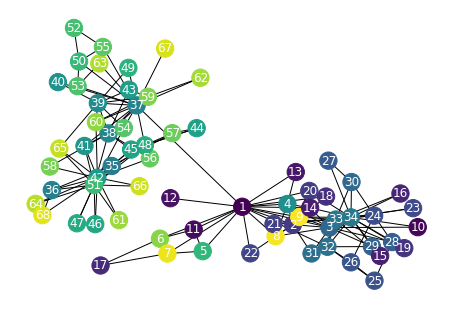

In [7]:
val_map = {}
c = 1/len(G.nodes())
#print(G.nodes())
#print(Embed)
for node in sorted(G.nodes()):
    val_map[node] = c
    c = c + 1/len(G.nodes())
    #print(f"node : {node} ---->   {Embed[node][1:]}")
for i in Embed:
    print(f"level : {i}")
    for node in Embed[i]:
        print (f"node : {node} ---> {Embed[i][node]}")
pos = nx.spring_layout(G, iterations=15)
values = [val_map.get(node, 0.25) for node in G.nodes()]
#pos = nx.spring_layout(G, iterations=200)
nx.draw(G, pos, cmap=plt.get_cmap('viridis'), node_color=values, with_labels=True, font_color='white')
plt.show()

In [10]:
fig = plt.figure(figsize=(18, 16))
#ax = plt.axes(projection='3d')
#lists = sorted(d.items()) 
#print(list(list(Embed.values())[1].values()))
#print(list(list(Embed.values())[1].keys()))
print(list(list(Embed1.values()))[1])

# Data for a three-dimensional line
#zline = Embed[1] #np.linspace(0, 15, 1000)
#xline = Embed[2] #np.sin(zline)
#yline = Embed[3] #np.cos(zline)
#ax.plot3D(xline, yline, zline, 'gray')
print(list(list(Embed.values()))[1])
c = [plt.cm.tab20(i) for i in range(20)]
for i in range(20):
    c.append(plt.cm.tab20b(i))
    c.append(plt.cm.tab20c(i) )
for i in range(10):
    c.append(plt.cm.tab10(i))
    c.append(plt.cm.Paired(i))
    c.append(plt.cm.Set3(i))
print(len(c))
colors = iter([i for i in c])
#colors.append(iter([plt.cm.tab20b(i) for i in range(20)]))
#colors.append(iter([plt.cm.tab20c(i) for i in range(20)]))
#colors.append(iter([plt.cm.tab10(i) for i in range(20)]))


# Data for three-dimensional scattered points
#zdata = Embed[1]
xdata = list(list(Embed.values())[1].values())
ydata = list(list(Embed.values())[2].values())
keys = list(list(Embed.values())[1].keys())

for i in range(len(xdata)):
    color = c[i%len(c)]#next(colors)
    plt.scatter(xdata[i]+rd.uniform(-0.01,0.01), ydata[i] ,c = color ,marker='x', label=Embed)
    plt.annotate(keys[i], xy=(xdata[i]+rd.uniform(-0.25,0.25), ydata[i]+rd.uniform(-0.5,0.5)),backgroundcolor=color,alpha=.5)
    #plt.scatter(xdata, ydata ,c = next(colors),cmap=plt.get_cmap('viridis') ,marker='x', label=Embed)

#for i in range(len(keys)):
    #plt.annotate(keys[i], xy=(xdata[i]-1, ydata[i]),backgroundcolor='1',alpha=.75)
plt.savefig('./fig.png')
plt.show()
#ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap=plt.get_cmap('viridis'));


NameError: name 'Embed1' is not defined

<Figure size 1296x1152 with 0 Axes>

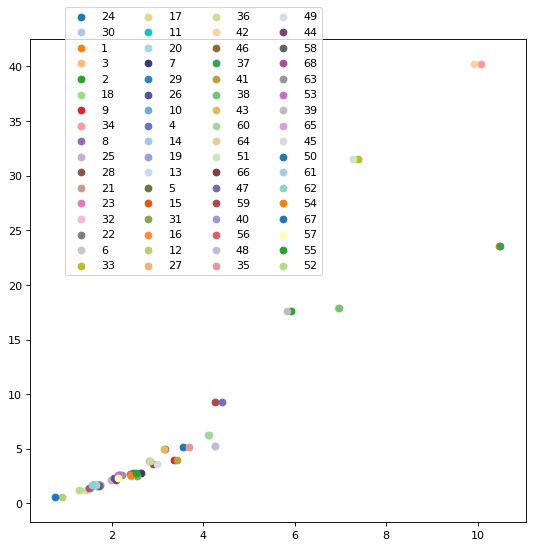

In [11]:
def plot_embeddings(embeddings,):
    xdata = list(list(Embed.values())[1].values())
    ydata = list(list(Embed.values())[2].values())
    keys = list(list(Embed.values())[1].keys())

    #X, Y = read_node_label('karate-mirrored.txt')
    c = [plt.cm.tab20(i) for i in range(20)]
    for i in range(20):
        c.append(plt.cm.tab20b(i))
        c.append(plt.cm.tab20c(i) )
    for i in range(10):
        c.append(plt.cm.tab10(i))
        c.append(plt.cm.Paired(i))
        c.append(plt.cm.Set3(i))
    #print(len(c))
    colors = iter([i for i in c])
    emb_list = []
    #for k in X:
        #emb_list.append(embeddings[k])
    #print(X)
    #emb_list = np.array(emb_list)
    
    #model = TSNE(n_components=2)
    #node_pos = model.fit_transform(emb_list)

    #color_idx = {}
    #for i in range(len(X)):
        #color_idx.setdefault(Y[i][0], [])
        #color_idx[Y[i][0]].append(i)
    plt.figure(figsize=(8, 8), dpi=80)
    for i in range(len(xdata)):#color_idx.items():
        C = next(colors)
        plt.scatter(xdata[i]+rd.uniform(-0.1,0.1), ydata[i], label=keys[i], c=C)
        #plt.annotate(keys[i], xy=(xdata[i]+rd.uniform(-0.5,0.5), ydata[i]+2),backgroundcolor=C,alpha=.15)
        #plt.annotate(c, xy=(node_pos[idx, 0], node_pos[idx, 1]),alpha=.5)
    plt.legend( bbox_to_anchor=(0.6,0.5),ncol=4)
    plt.savefig('path2vec.png')
    plt.show()
plot_embeddings(Embed)

In [54]:
plt.rcParams["figure.figsize"] = (20,15)

In [13]:
xdata = list(list(Embed.values())[1].values())
ydata = list(list(Embed.values())[2].values())
keys = list(list(Embed.values())[1].keys())

coor = [0 for i in range(len(keys))]
y = [0 for i in range(len(keys))]

for i in range(len(xdata)):
    y[int(keys[i])-1] = keys[i] 
    coor[int(keys[i])-1] = np.array((xdata[i],ydata[i]))
    
    
#coor = sorted(coor.items())
print (type(coor[0]))

dist = [[0 for i in range(len(coor))] for j in range(len(coor))]
ref = [0 for i in range(len(coor))]
r = np.array((0,0))
for i in range(len(coor)):
    ref[i]  = np.sqrt(np.sum(np.square(coor[i] - r)))
    for j in range(len(coor)):
        #print(f"{i} {j}")
        #print( f" {coor[i]} , {coor[j]} ")
        dist[i][j] = np.sqrt(np.sum(np.square(coor[i] - coor[j])))# np.linalg.norm((coor[i],coor[j]))
        
        #print(np.sqrt(np.sum(np.square(coor[i] - coor[j]))))
        
        

print(type(dist))
#dist = np.linalg.norm(a-b)
#print(type(np.array(coor[2][1].tolist())))
#print(np.linalg.norm(np.array(coor[1][1]),np.array(coor[2][1])))
print(len(keys))
print(len(coor))
print(len(xdata))

<class 'numpy.ndarray'>
<class 'list'>
68
68
68


In [111]:
dist[0][0]

0.0

"\nfig = plt.figure()\nax = plt.axes(projection='3d')\nax.contour3D(X, Y, Z, 50, cmap='binary')\nax.set_xlabel('x')\nax.set_ylabel('y')\nax.set_zlabel('z')\n"

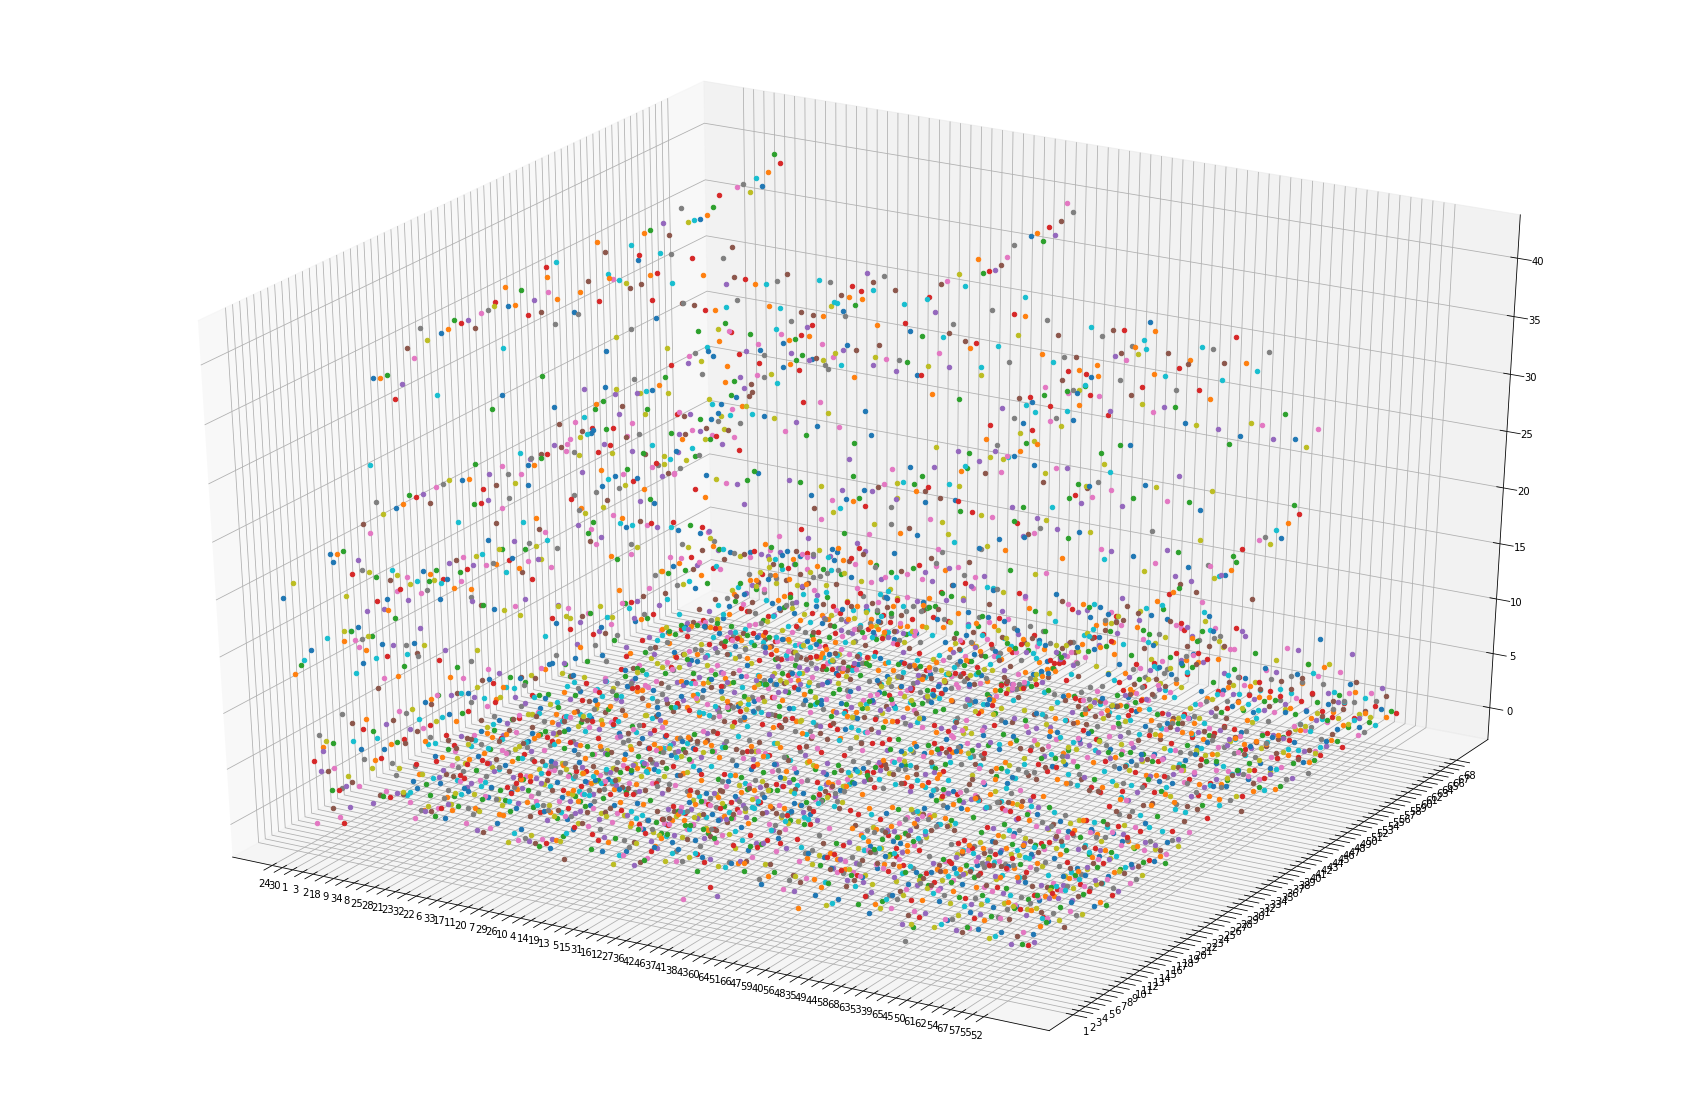

In [14]:

ax = plt.axes(projection='3d')

def f(x, y):
    return dist[x-1][y-1]

x = keys

#X, Y = np.meshgrid(x, y)
for i in x:
    #l = f"node {x[int(i)-1]} "
    #plt.plot(x, dist[int(i)-1], label = l ,marker='x',linestyle='dashed',alpha = .4)
    for j in y:
        ax.scatter3D(i, j, f(int(i),int(j)), cmap='Greens');
plt.savefig('3d.png')
#Z = f(X, Y)
'''
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
'''



In [17]:
np.var(dist)

114.23268541852917

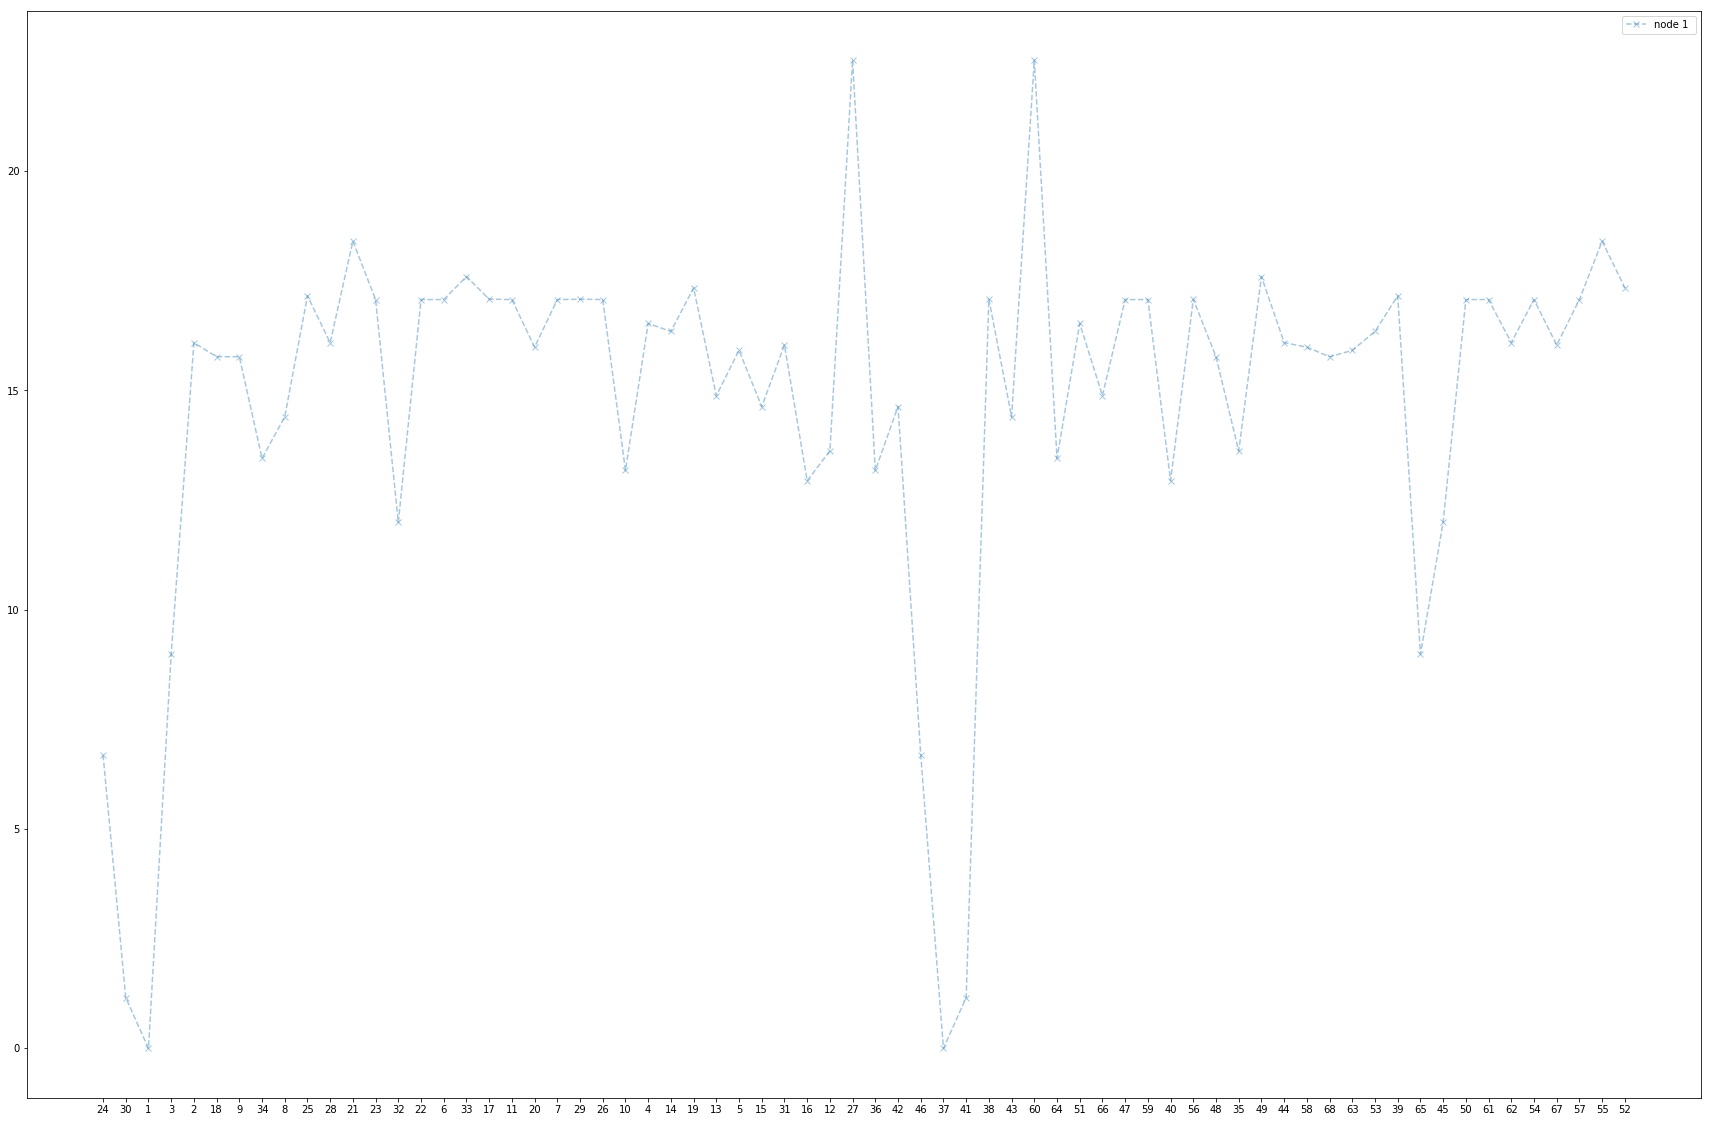

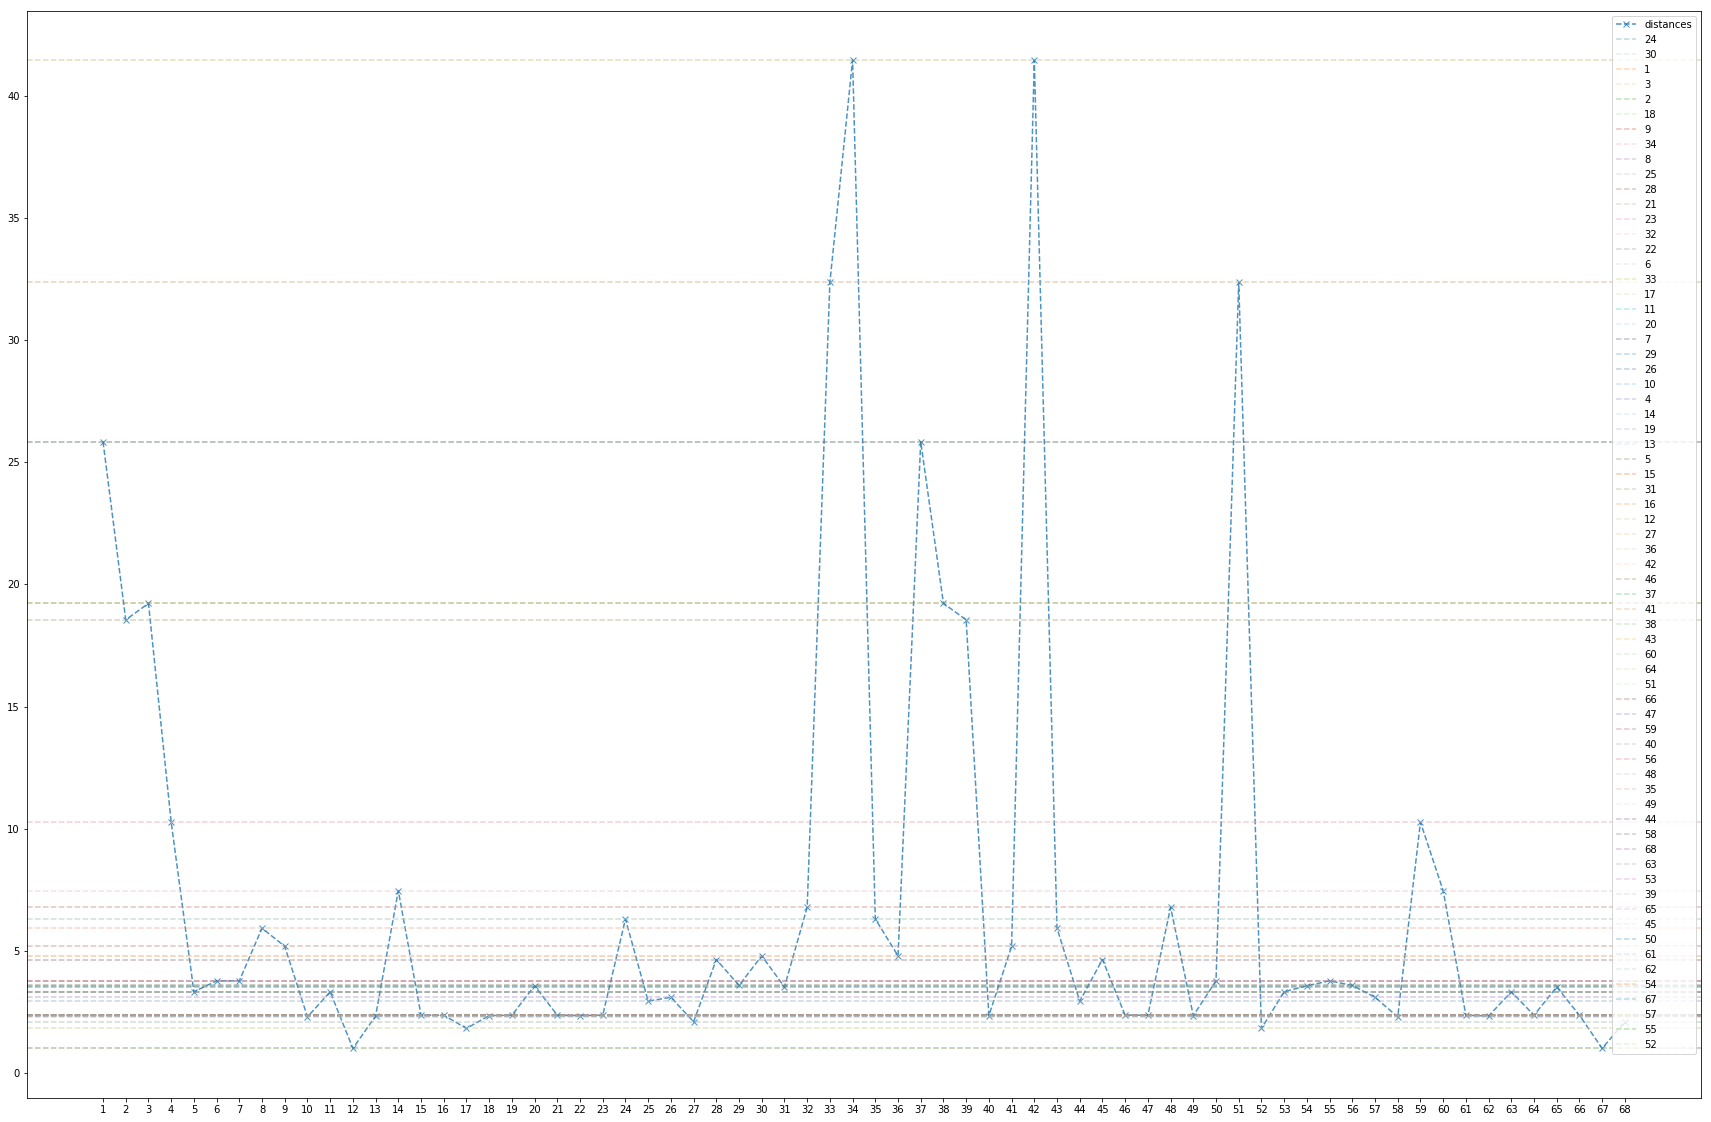

In [15]:


c = [plt.cm.tab20(i) for i in range(20)]
for i in range(20):
    c.append(plt.cm.tab20b(i))
    c.append(plt.cm.tab20c(i) )
for i in range(10):
    c.append(plt.cm.tab10(i))
    c.append(plt.cm.Paired(i))
    c.append(plt.cm.Set3(i))
#print(len(c))
colors = iter([i for i in c])

for i in range(1):
    l = f"node {x[2]} "
    plt.plot(x, dist[2], label = l ,marker='x',linestyle='dashed',alpha = .4)
    #plt.stem(x, dist[i], label = l ,marker='x',linestyle='dashed')
    
    #plt.plot(x, dist[0], label = "line 1",marker='x')
#plt.rcParams["figure.figsize"] = (30,20)
plt.legend()
plt.savefig('node1.png')
plt.show()

plt.plot(y, ref, label = 'distances' ,marker='x',linestyle='dashed',alpha = .8)
m=0
for i in ref:
    
    plt.axhline(y=i, linestyle='--',alpha=.3,color=next(colors),label=x[m]) 
    m+=1
plt.legend()
plt.savefig('distance.png')

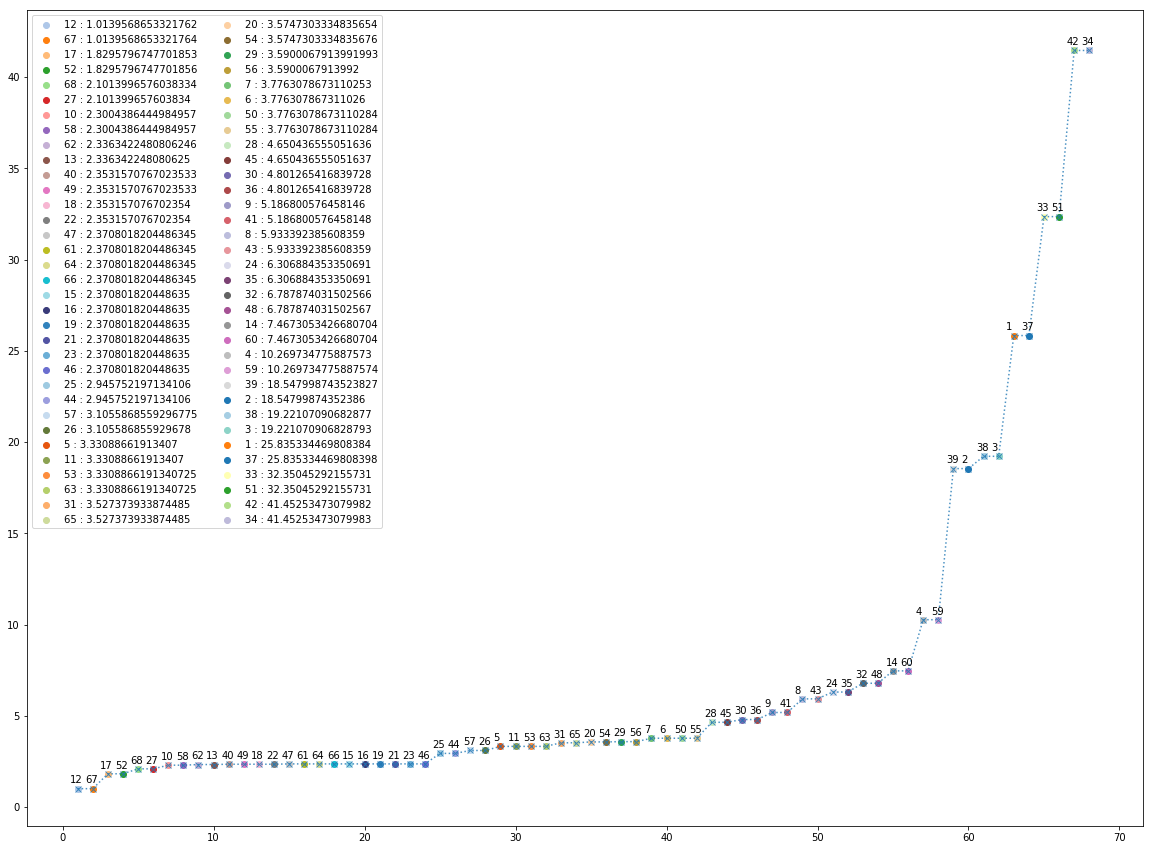

In [56]:
#print(ref)
m=1
on = {}
colors = iter([i for i in c[1:]])
for k, v in sort.items():
    C = next(colors)
    l = f"{k} : {v}"
    plt.scatter(m, v,label=l, c=C)
    plt.annotate(k, xy=(m-0.5,v+0.3))#,backgroundcolor=C,alpha=.7)
    
    on[m] = v
    m+=1
    
plt.plot(on.keys(),on.values()  ,marker='x',linestyle='dotted',alpha = .8)
plt.legend(ncol=2)
plt.savefig("pairs.png")
#plt.plot(y, ref, label = 'distances' ,marker='x',linestyle='dashed',alpha = .8)
#sort = {k: v for k, v in sorted(sort.items(), key=lambda item: item[1])}

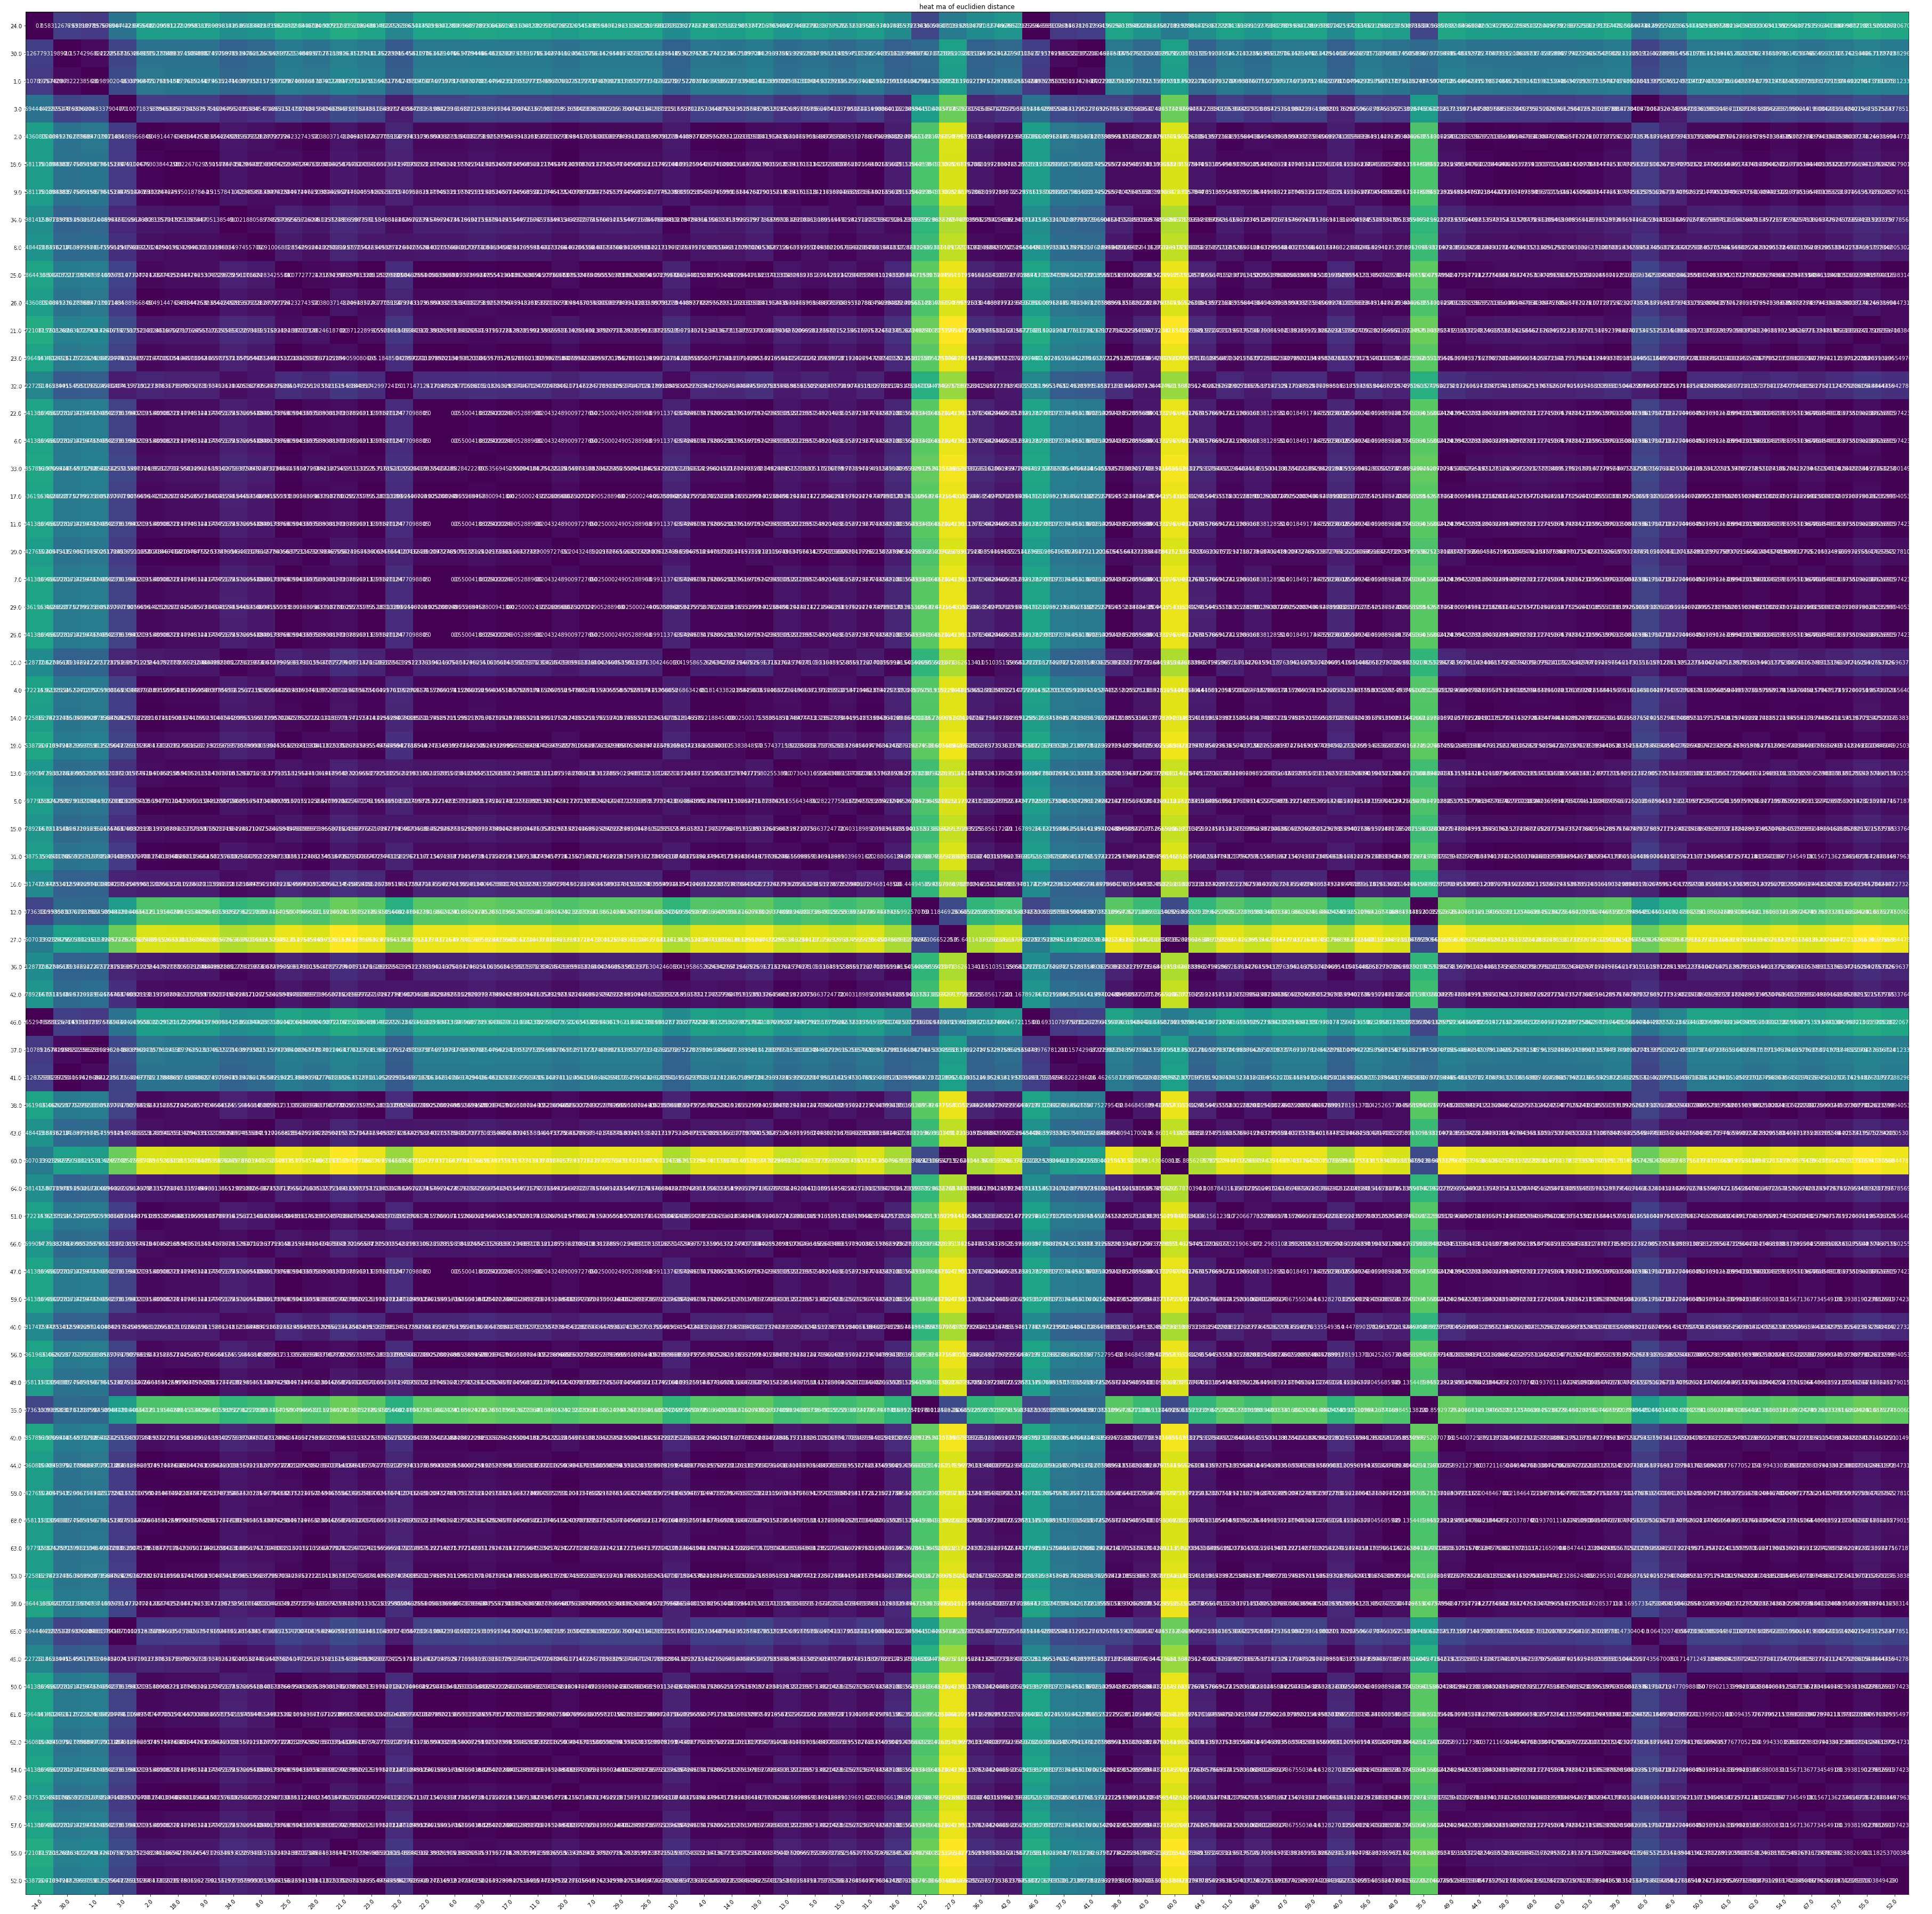

In [50]:

fig, ax = plt.subplots()
im = ax.imshow(dist)

# We want to show all ticks...
ax.set_xticks(np.arange(len(x)))
ax.set_yticks(np.arange(len(y)))
# ... and label them with the respective list entries
ax.set_xticklabels(x)
ax.set_yticklabels(y)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(x)):
    for j in range(len(y)):
        text = ax.text(j, i, dist[i][j],
                       ha="center", va="center", color="w")

ax.set_title("heat ma of euclidien distance")
fig.tight_layout()
plt.savefig('heat.png')
plt.show()

In [ ]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

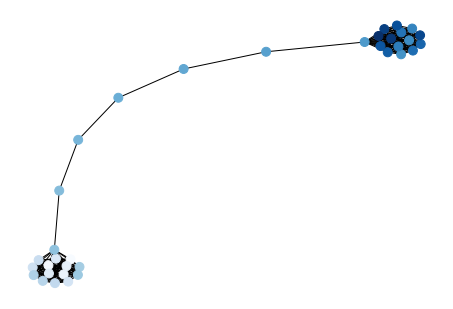

In [8]:
G = Graphs.barbell_graph(15,5)
pos = nx.spring_layout(G, iterations=200)
nx.draw(G, pos, node_color=range(35), node_size=80, cmap=plt.cm.Blues)
plt.show()

In [ ]:
def nodes_connected(G, u, v):
    return u in G.neighbors(v)

def collectAdarScores(G, train_edges_name):
    
    # find which edges are unconnected in the training
    df_train = pd.read_csv(train_edges_name)
    df_train = df_train.replace(np.nan, 'nan', regex=True)
    #print(G.neighbors('nan'))
    #print(err)
    #list_unconnected = df_train.index[df_train['training_labels'] == 0].tolist() #df_train.where(df_train['training_labels']==0))

    list_real_labels = []
    list_pred_scores = []
    count =0
    for i_row in range(len(df_train.node1)): # for each training set data
        node1 = df_train.node1[i_row]
        node2 = df_train.node2[i_row]
        print(count)
        count = count + 1
        if(node1=='nan' or node2=='nan'):
            print('node1 :   '+str(node1)+'           node2 :'+str(node2))
            continue     
        # Find all nbrs of node1 and node2 in training graph that overlap
        list_nbrs = sorted(nx.common_neighbors(G, node1, node2))
            
        total_sum = 0
        # if list_nbrs isn't empty, find the weights of all the edges connected to the nbrs
        for i in range(len(list_nbrs)):
            curr_weight = G.degree(list_nbrs[i], weight='weight')
            total_sum += -1/np.log(curr_weight)

        #
        list_real_labels.append(df_train.labels[i_row])
        list_pred_scores.append(total_sum)

    return list_pred_scores, list_real_labels

def computeAccuracy(list_pred_res, list_real_res):

    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i_ in range(len(list_pred_res)):

        # find out if the nodes are connected in the g_test
        is_connected = list_real_res[i_]
        prediction = list_pred_res[i_, 1]

        if is_connected and prediction >= 0.5:
            tp += 1
        elif is_connected and prediction < 0.5:
            fn += 1
        elif not is_connected and prediction < 0.5:
            tn += 1
        elif not is_connected and prediction >= 0.5:
            fp += 1
        else:
            print('Error!')

        i_ += 1
    
    return tp, tn, fp, fn

In [ ]:
def applyNaiveBayes(save_dir, method_):

    fo = open(save_dir + 'accuracy_test_results_baseline_naive_bayes.txt', 'w')
    fo.write('set\ttp\ttn\tfp\tfn\tacc\n')

    foval = open(save_dir + 'accuracy_val_results_baseline_naive_bayes.txt', 'w')
    fo.write('set\ttp\ttn\tfp\tfn\tacc\n')
    # read the A_train graph
    for ix in range(1, 6):
        
        # ---------------- training ----------------------
        train_graph_name = './graphs/graph_sampled_' + str(ix) + '.gml.gz'
        G = nx.read_gml(train_graph_name)

        train_edges_name = './graphs/graph_train_edges_sampled_' + str(ix) + '.csv'

        list_pred_scores_train, list_real_labels_train = collectAdarScores(G, train_edges_name)

        #Create a Gaussian Classifier
        model = GaussianNB()

        # Train the model using the training sets
        model.fit(np.array(list_pred_scores_train).reshape(-1, 1),list_real_labels_train) # which score corresponds to which label

        # --------------- validation ---------------------------
        val_edges_name = './graphs/graph_val_edges_sampled_' + str(ix) + '.csv'

        # compute the performance over validation set
        list_pred_scores_val, list_real_labels_val = collectAdarScores(G, val_edges_name)
        list_pred_labels_val = model.predict_proba(np.array(list_pred_scores_val).reshape(-1, 1))

        tp_v, tn_v, fp_v, fn_v = computeAccuracy(list_pred_labels_val, list_real_labels_val)
        acc_v = (tp_v+tn_v)/float(tp_v+tn_v+fp_v+fn_v)
        foval.write('val\t' + str(tp_v) + '\t' + str(tn_v) + '\t' + str(fp_v) + '\t' + str(fn_v) + '\t' + str(acc_v) + '\n')
        # --------------- test ------------------------------------
        #test_graph_name = 'graphs/graph_test_' + str(ix) + '.gml.gz'
        test_edges_name = './graphs/graph_test_edges_sampled_' + str(ix) + '.csv'

        if 'adar' in method_:
            list_pred_scores_test, list_real_labels_test = collectAdarScores(G, test_edges_name)
        else:
            list_pred_scores_test, list_real_labels_test = collectJaccardScores(G, test_edges_name)
        list_pred_labels_test = model.predict_proba(np.array(list_pred_scores_test).reshape(-1, 1))

        fo__ = open(save_dir + 'prediction_results_test_naivebayes_' + str(ix) + '.txt', 'w')
        for icurrpred in range(len(list_pred_labels_test)):
            fo__.write(str(list_pred_labels_test[icurrpred, 1]) + '\t' + str(list_real_labels_test[icurrpred]) + '\n')
        fo__.close()
        # compute the performance over test set
        tp_t, tn_t, fp_t, fn_t = computeAccuracy(list_pred_labels_test, list_real_labels_test)
        acc_t = (tp_t+tn_t)/float(tp_t+tn_t+fp_t+fn_t)
        fo.write('test\t' + str(tp_t) + '\t' + str(tn_t) + '\t' + str(fp_t) + '\t' + str(fn_t) + '\t' + str(acc_t) + '\n')
        del G

    fo.close()
    foval.close()

In [ ]:
def applyLogisticRegression(save_dir, method_):

    fo = open(save_dir + 'accuracy_test_results_baseline_logit.txt', 'w')
    fo.write('set\ttp\ttn\tfp\tfn\tacc\n')

    foval = open(save_dir + 'accuracy_val_results_baseline_logit.txt', 'w')
    fo.write('set\ttp\ttn\tfp\tfn\tacc\n')
    # read the A_train graph
    for ix in range(1, 6):
        
        # ---------------- training ----------------------
        train_graph_name = './graphs/graph_sampled_' + str(ix) + '.gml.gz'
        G = nx.read_gml(train_graph_name)

        train_edges_name = './graphs/graph_train_edges_sampled_' + str(ix) + '.csv'

        list_pred_scores_train, list_real_labels_train = collectAdarScores(G, train_edges_name)

        #Create LR classifier
        model = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=2000)

        # Train the model using the training sets
        model.fit(np.array(list_pred_scores_train).reshape(-1, 1),list_real_labels_train) # which score corresponds to which label

        # --------------- validation ---------------------------
        val_edges_name = './graphs/graph_val_edges_sampled_' + str(ix) + '.csv'

        # compute the performance over validation set
        list_pred_scores_val, list_real_labels_val = collectAdarScores(G, val_edges_name)
        list_pred_labels_val = model.predict_proba(np.array(list_pred_scores_val).reshape(-1, 1))

        tp_v, tn_v, fp_v, fn_v = computeAccuracy(list_pred_labels_val, list_real_labels_val)
        acc_v = (tp_v+tn_v)/float(tp_v+tn_v+fp_v+fn_v)
        foval.write('val\t' + str(tp_v) + '\t' + str(tn_v) + '\t' + str(fp_v) + '\t' + str(fn_v) + '\t' + str(acc_v) + '\n')
        # --------------- test ------------------------------------
        #test_graph_name = 'graphs/graph_test_' + str(ix) + '.gml.gz'
        test_edges_name = './graphs/graph_test_edges_sampled_' + str(ix) + '.csv'

        if 'adar' in method_:
            list_pred_scores_test, list_real_labels_test = collectAdarScores(G, test_edges_name)
        else:
            list_pred_scores_test, list_real_labels_test = collectJaccardScores(G, test_edges_name)
        list_pred_labels_test = model.predict_proba(np.array(list_pred_scores_test).reshape(-1, 1))

        fo__ = open(save_dir + 'prediction_results_test_logit_split' + str(ix) + '.txt', 'w')
        for icurrpred in range(len(list_pred_labels_test)):
            fo__.write(str(list_pred_labels_test[icurrpred, 1]) + '\t' + str(list_real_labels_test[icurrpred]) + '\n')
        fo__.close()
        # compute the performance over test set
        tp_t, tn_t, fp_t, fn_t = computeAccuracy(list_pred_labels_test, list_real_labels_test)
        acc_t = (tp_t+tn_t)/float(tp_t+tn_t+fp_t+fn_t)
        fo.write('test\t' + str(tp_t) + '\t' + str(tn_t) + '\t' + str(fp_t) + '\t' + str(fn_t) + '\t' + str(acc_t) + '\n')
        del G

    fo.close()
    foval.close()

In [ ]:
# inside, save the trained model to the corresponding folder - might be needed in the future
def trainTheClassifier(training_matrix, training_labels, validation_matrix, validation_labels):

    num_features = np.shape(training_matrix)[1]

    # define the early stopping criteria
    es = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=25, verbose=0, mode='auto', restore_best_weights=True)# 

    # define the model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(100, activation='tanh', input_shape=(num_features,)))
    #model.add(keras.layers.Dropout(0.25))
    #model.add(keras.layers.Dense(80, activation='relu', kernel_initializer='he_normal'))
    #model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(50, activation='tanh'))
    #model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(10, activation='tanh'))
    #model.add(keras.layers.Dropout(0.25))
    #model.add(keras.layers.Dense(5, activation='relu', kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(2, activation='sigmoid'))

    # with sgd optimizer, the result was 0.74, i just replaced it with adam and got 0.88 - the highest performance so far
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_crossentropy', 'accuracy'])

    model.fit(training_matrix, np.asarray(training_labels), epochs=200, batch_size=2500,
                  validation_data=(validation_matrix, np.asarray(validation_labels)), callbacks=[es])

    return model

def classifyFeatures(input_matrix, trained_model):

    probas_ = trained_model.predict(input_matrix)

    return probas_

In [ ]:
def applyDeepLearning(save_dir, method_):

    fo = open(save_dir + 'accuracy_test_results_baseline_mp.txt', 'w')
    fo.write('set\ttp\ttn\tfp\tfn\tacc\n')

    #foval = open('accuracy_val_results_baseline_mp.txt', 'w')
    #fo.write('set\ttp\ttn\tfp\tfn\tacc\n')
    # read the A_train graph
    for ix in range(1, 6):#range(1, 6)
        
        # ---------------- training ----------------------
        train_graph_name = './graphs/graph_sampled_' + str(ix) + '.gml.gz'
        G = nx.read_gml(train_graph_name)

        train_edges_name = './graphs/graph_train_edges_sampled_' + str(ix) + '.csv'

        list_pred_scores_train, list_real_labels_train = collectAdarScores(G, train_edges_name)

        # --------------- validation ---------------------------
        val_edges_name = './graphs/graph_val_edges_sampled_' + str(ix) + '.csv'

        # compute the performance over validation set
        list_pred_scores_val, list_real_labels_val = collectAdarScores(G, val_edges_name)
        
        # train and fit the deep learning model np.array(list_pred_scores).reshape(-1, 1)
        model = trainTheClassifier(np.array(list_pred_scores_train).reshape(-1, 1), list_real_labels_train, np.array(list_pred_scores_val).reshape(-1, 1), list_real_labels_val)

        # --------------- test ------------------------------------
        #test_graph_name = 'graphs/graph_test_' + str(ix) + '.gml.gz'
        test_edges_name = './graphs/graph_test_edges_sampled_' + str(ix) + '.csv'

        if 'adar' in method_:
            list_pred_scores_test, list_real_labels_test = collectAdarScores(G, test_edges_name)
        else:
            list_pred_scores_test, list_real_labels_test = collectJaccardScores(G, test_edges_name)
        list_pred_labels_test = classifyFeatures(np.array(list_pred_scores_test).reshape(-1, 1), model)

        fo__ = open(save_dir + 'prediction_results_test_mp_' + str(ix) + '.txt', 'w')
        for icurrpred in range(len(list_pred_labels_test)):
            fo__.write(str(list_pred_labels_test[icurrpred, 1]) + '\t' + str(list_real_labels_test[icurrpred]) + '\n')
        fo__.close()
        # compute the performance over test set
        tp_t, tn_t, fp_t, fn_t = computeAccuracy(list_pred_labels_test[:, 1], list_real_labels_test)
        acc_t = (tp_t+tn_t)/float(tp_t+tn_t+fp_t+fn_t)
        fo.write('test\t' + str(tp_t) + '\t' + str(tn_t) + '\t' + str(fp_t) + '\t' + str(fn_t) + '\t' + str(acc_t) + '\n')
        del G

    fo.close()
    #foval.close()

def collectJaccardScores(G, train_edges_name):
    
    # find which edges are unconnected in the training
    df_train = pd.read_csv(train_edges_name)
    df_train = df_train.replace(np.nan, 'nan', regex=True)
    #print(G.neighbors('nan'))
    #print(err)
    #list_unconnected = df_train.index[df_train['training_labels'] == 0].tolist() #df_train.where(df_train['training_labels']==0))

    list_real_labels = []
    list_pred_scores = []
    for i_row in range(len(df_train.node1)): # for each training set data
        node1 = df_train.node1[i_row]
        node2 = df_train.node2[i_row]

        # Find all nbrs of node1 and node2 in training graph that overlap
        list_commonnbrs = sorted(nx.common_neighbors(G, node1, node2))
        
        sum_common = 0
        # if list_nbrs isn't empty, find the weights of all the edges connected to the nbrs
        for i in range(len(list_commonnbrs)):
            curr_weight = G.degree(list_commonnbrs[i], weight='weight')
            sum_common += curr_weight
        
        list_allnbrs1 = list(G.neighbors(node1))#[n for n in G.neighbors(node1)]
        list_allnbrs2 = list(G.neighbors(node2))#[n for n in G.neighbors(node2)] #[n for n in G.neighbors(0)]
        list_mergednbrs = list(set(list_allnbrs1 + list_allnbrs2))
        #print('Num node1 ' + str(len(list_allnbrs1)))
        #print('Num node2 ' + str(len(list_allnbrs2)))
        #print('Num total ' + str(len(list_mergednbrs)))

        sum_union = 0
        # if list_nbrs isn't empty, find the weights of all the edges connected to the nbrs
        for i in range(len(list_mergednbrs)):
            curr_weight = G.degree(list_mergednbrs[i], weight='weight')
            sum_union += curr_weight
        
        if sum_union > 0:
            total_res = sum_common/float(sum_union)
        else:
            total_res = 0
        #
        list_real_labels.append(df_train.labels[i_row])
        list_pred_scores.append(total_res)

    return list_pred_scores, list_real_labels